# Small noise approximation - mRNA level

In [3]:
import glob
# Our numerical workhorses
import numpy as np
import scipy.optimize
import scipy.special
import scipy.integrate
import mpmath

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# Import the utils for this project
import chann_cap_utils as chann_cap

# Set PBoC plotting style
chann_cap.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# figdir = '../../fig/chemical_master_analytic_protein/'
tmpdir = '../../tmp/'

### $\LaTeX$ macros

$\newcommand{\meanm}{\langle m \rangle}$
$\newcommand{\rm}{r_m}$
$\newcommand{\gm}{\gamma_m}$
$\newcommand{\kon}{k_{\text{on}}}$
$\newcommand{\koff}{k_{\text{off}}}$
$\newcommand{\depsilon}{\Delta \varepsilon}$

## The small noise approximation.

In this notebook we will explore the use of the small noise approximation in the context of the information processing capacity of the simple repression motif at steady state focusing on the mRNA level.

As derived by Tkacik, Callan and Bialek in their [2008 Phys Rev E paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.78.011910), if one assumes the small noise approximation is valid, computing the channel capacity of a genetic regulatory system becomes analytically tractable.
The calculation requires a mapping between the input (in our case $c$ the inducer concentration) and the **mean output** (for this particular notebook the mean mRNA copy number $\meanm$). Since these means are deterministic functions of the input we can use the change of variables
$$
P_c(c) dc = P_{\meanm} (\meanm) d \meanm.
$$
In that case the optimal distribution $P^*_c(c)$ can be mapped to the optimal mean output distribution $P^*_{\meanm}(\meanm)$.

Using this change of variables and the small noise approximation (SMA) the optimal mean output distribution is given by
$$
P^*(\meanm) = {1 \over \mathcal{Z}} {1 \over \sigma_{\meanm}(\meanm)},
$$
where $\mathcal{Z}$ is a normalization constant of the form
$$
\mathcal{Z} = \int_{\meanm _\min}^{\meanm _\max} 
              {d\meanm \over \sigma_{\meanm}\left( \meanm \right)}.
$$

Giventhis optimal distribution it can be shown that the channel capacity 
$I^*(c;\meanm)$ is given by
$$
I^*(c;\meanm) = \log_2 \left( {\mathcal{Z} \over \sqrt{2\pi e}} \right).
$$

So with this amazing and simple result all we need is an expression for the noise $\sigma_{\meanm}$ as a function of the mean output $\meanm$ in order to compute the channel capacity of our system of interest!

## mRNA level channel capacity.
As derived using the two-state promoter chemical master equation the mean mRNA copy number at this level is given by
$$
\meanm = {\rm \over \gm}{\kon \over \kon + \koff},
$$
where $\rm$ is the mRNA production rate $\gm$ is the degradation rate, $\kon$ is the rate to transition from inactive to active promoter and $\koff$ is the rate to transition from active to inactive.

The variance in gene expression again as derived using chemical master equations is of the form
$$
\sigma_{\meanm}^2 = \meanm \left( 1 + {\koff \over \kon + \koff}
                            {\rm \over \koff + \kon + \gm}\right).
$$

For the case of the induction we have that $\meanm \equiv \meanm(\koff)$, i.e. the only variable that changes as we increase the induction concentration is assumed to be the rate $\koff$. That means that in performing the integral to compute $\mathcal{Z}$ we have to take into account the fact that this rate will change within the limits of the integral. To account for that let's use the expression for the mean mRNA copy number and solve for $\koff$

**Note: This has already been done manually but I'll implement an algebraic solver with `sympy` to double check the results.**

In [22]:
# Define the sympy variables
r, gamma = sympy.symbols('r gamma')
kon, koff = sympy.symbols('k_{{on}} k_{{off}}')
mm = sympy.Symbol('\\langle m \\rangle')
sigmam = sympy.Symbol('\\sigma_{\\langle m \\rangle}')

r, gamma, kon, koff, mm, sigmam

Having defined the variables let's find the expression that connects $\meanm$ with $\koff$

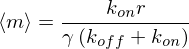

In [25]:
# Define the equation for the mean mRNA copy number
mean_mRNA = sympy.Eq(mm , (r / gamma) * kon / (kon + koff))
mean_mRNA

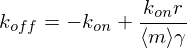

In [32]:
# Solve the equation for koff to find a relationship between koff and <m>
koff_m_func = sympy.solve(mean_mRNA, koff)[0]
sympy.Eq(koff, koff_m_func)

Having this relationship allow us to now use the equation for the variance in mRNA copy number. Let's declare the `sympy` function for the variance

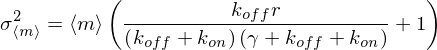

In [34]:
# Define function for variance
var_mRNA = mm * (1 + koff / (kon + koff) * r / (kon + koff + gamma))
sympy.Eq(sigmam**2, var_mRNA)

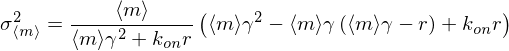

In [42]:
# Substitute koff for the relationship with mean mRNA
var_mRNA_m_func = sympy.simplify(var_mRNA.subs(koff, koff_m_func))

sympy.Eq(sigmam**2, var_mRNA_m_func)

Having this expression let's check if sympy can perform the integral for this case.

In [ ]:
# Z_int = sympy.integrate(1 / sympy.sqrt(var_mRNA_m_func), mm)

It seems that `sympy` cannot solve this integral. Mathematica on the other side can solve the integral and it is a horrible and useless equation. The numerical integration will be the actual intuitive result for this. Nevertheless here is Mathematica's result
$$\scriptstyle{
-\frac{2 \sqrt{2} m \sqrt{-\frac{k r+\gamma ^2 m}{\gamma  m \left(-\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)}} \left(\sqrt{\frac{-\gamma  m \left(\gamma -\sqrt{4 k
   r+(\gamma +r)^2}+r\right)-2 k r}{\gamma  m \sqrt{4 k r+(\gamma +r)^2}}} \left(\gamma  m (\gamma +r) \left(\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)+k r \left(\gamma
   +\sqrt{4 k r+(\gamma +r)^2}+2 \gamma  m+r\right)\right) F\left(\sin ^{-1}\left(\frac{\sqrt{\frac{\frac{2 k r}{m}+\gamma  \left(r+\gamma +\sqrt{(r+\gamma )^2+4 k
   r}\right)}{\gamma  \sqrt{(r+\gamma )^2+4 k r}}}}{\sqrt{2}}\right)|\frac{2 \sqrt{(r+\gamma )^2+4 k r}}{r-\gamma +\sqrt{(r+\gamma )^2+4 k r}}\right)-2 \gamma ^2 m
   \sqrt{4 k r+(\gamma +r)^2} \sqrt{-\frac{k r (k r+\gamma  m (\gamma -\gamma  m+r))}{\gamma ^2 m^2 \left(4 k r+(\gamma +r)^2\right)}} \sqrt{\frac{\frac{2 k r}{m}+\gamma 
   \left(\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)}{\gamma  \sqrt{4 k r+(\gamma +r)^2}}} \Pi \left(\frac{2 \sqrt{(r+\gamma )^2+4 k r}}{r+\gamma +\sqrt{(r+\gamma )^2+4 k
   r}};\sin ^{-1}\left(\frac{\sqrt{\frac{\frac{2 k r}{m}+\gamma  \left(r+\gamma +\sqrt{(r+\gamma )^2+4 k r}\right)}{\gamma  \sqrt{(r+\gamma )^2+4 k
   r}}}}{\sqrt{2}}\right)|\frac{2 \sqrt{(r+\gamma )^2+4 k r}}{r-\gamma +\sqrt{(r+\gamma )^2+4 k r}}\right)\right)}{\left(\gamma +\sqrt{4 k r+(\gamma +r)^2}+r\right)
   \left(k r+\gamma ^2 m\right) \sqrt{\frac{m (k r+\gamma  m (\gamma -\gamma  m+r))}{k r+\gamma ^2 m}} \sqrt{\frac{\frac{2 k r}{m}+\gamma  \left(\gamma +\sqrt{4 k
   r+(\gamma +r)^2}+r\right)}{\gamma  \sqrt{4 k r+(\gamma +r)^2}}}}
   }
$$

## Numerical exploration of the channel capacity.

Given the unintuitive form of this equation we will make use of numerical integration to explore how different parameters affect the channel capacity.

First we define the inverse standard deviation function and generate a function to evaluate this expression numerically.

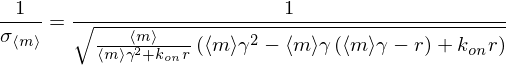

In [113]:
# Define the inverse standard deviation 
inv_sigma = 1 / sympy.sqrt(var_mRNA_m_func)
sympy.Eq(1 / sigmam, inv_sigma)


# inv_sigma_num = sympy.lambdify([mm, r, gamma, kon], inv_sigma, 'numpy')

In [114]:
def inv_sigma_num(mm, r_m, gamma_m, kon):
    '''
    Computes the inverse standard deviation for the mRNA copy number as derived
    from the chemical master equation.
    Parameters
    ----------
    mm : array-like.
        mean mRNA copy number.
    r_m : float.
        mRNA production rate.
    gamma_m : float.
        mRNA degradation rate.
    kon : float.
        rate to transition from inactive to active promoter.
    Returns
    -------
    1 / sigma_<m> : array-like.
        inverse standard deviation of the mRNA copy number
    '''
    return 1 / (mm / (mm * gamma_m**2 + kon * r_m) * \
           (mm * gamma_m**2 - mm ** gamma_m * \
           (mm * gamma_m - r_m) + kon * r_m))**(1/2)

### Limits of integration

The limits of integration to compute $\mathcal{Z}$ are $\meanm_\min$ and $\meanm_\max$. These limits indicate the mean number of mRNA produce in the absence of inducer ($\meanm_\min$) and the mRNA copy number at saturating concentrations of inducer ($\meanm_\max$).

These limits are given as (derivation show elsewhere):
$$
\meanm_\min = {\rm \over \gm} 
{1 \over 1 + {k_o \left[ R \right] \over \kon} \left( {1 \over 1 + e^{-\beta \depsilon_{AI}}} \right)},
$$
where $\depsilon_{AI}$ is the energy difference between the active and inactive state of the repressor. For the upper bound we have
$$
\meanm_\max = {\rm \over \gm} 
{1 \over 1 + {k_o \left[ R \right] \over \kon} \left( {1 \over 1 + e^{-\beta \depsilon_{AI}} \left( {K_A \over K_I} \right)^2 } \right)},
$$
where $K_A$ but $K_I$ are the dissociation constants of the inducer in the active and inactive state of the repressor, respectively.

Let's now define a function to perform the numerical integration in order to compute $\mathcal{Z}$.

In [122]:
sympy.init_printing(use_unicode=False) # print outputs in LaTeX

In [123]:
def sma_mRNA_num(gamma_m, r_gamma_m, ko, kon, R, e_AI=4.5, Ka=139.55, Ki=.53):
    '''
    Computes the integral of the inverse standard deviation of the mRNA copy
    number as dictated by the small-noise approximation. The limits of
    integration are taken to be the mean mRNA copy number in the absense of
    inducer and in saturating concentrations of inducer.
    Parameters
    ----------
    gamma_m : float.
        mRNA degradation rate.
    r_gamma_m : float.
        ratio of r_m / gamma_m measured as the mean mRNA copy number of an
        unregulated promoter
    ko : float.
        diffusion limited rate for the repressor to bind the operator.
    kon : float.
        rate of transition from inactive to active promoter.
    R : float.
        repressor copy number per cell
    e_AI : float.
        energy difference between active and inactive repressor in kBT units
    Ka, Ki : float.
        dissociation constants of the inducer in the active and inactive state
        respectively. (Must have the same units).
    Returns
    -------
    Z : integral of the inverse variance for mRNA copy number.
    '''
    # Convert number of repressors to concentration
    R_conc = R * 1.66
    
    # Obtain r_m from the r_gamma_m and gamma_m product
    r_m = r_gamma_m * gamma_m
    
    # Compute the pact max and min
    pact_max = 1 / (1 + np.exp(-e_AI)) # when C = 0
    pact_min = 1 / (1 + np.exp(-e_AI) * (Ka / Ki)**2) # when C -> oo
    
    # Compute the integration limits
    m_min = r_gamma_m * 1 / (1 + (ko * R_conc / kon) * pact_max)
    m_max = r_gamma_m * 1 / (1 + (ko * R_conc / kon) * pact_min)
    
    # Pack the arguments to be passed to the inverse std function
    args = (r_m, gamma_m, kon)
    
    # Compute the integral
    Z, err = scipy.integrate.quad(inv_sigma_num, m_min, m_max, args=args)
    
    return np.log2(Z / np.sqrt(2 * np.pi * np.e))

##### Brewster & Jones parameters.

Let's compute the channel capacity for each of the operators as a function of the repressor copy number using the parameters reported by Brewster & Jones.

In [158]:
# Define dictionary containing the kon rates according to Jones & Brewster
kon_dict = {'Oid': 0.0023, 'O1': 0.0069, 'O2': 0.091, 'O3': 2.1}

# Prepare dictionary with all relevant parameters
sma_params = dict(gamma_m=0.00284, r_gamma_m=15.7,
                ko=2.7E-3)

# Define array of number of repressors to evaluate
R_array = np.logspace(0, 4, 100)

In [159]:
# Initialize matriz to save channel capacities
channel_cap = np.zeros([len(kon_dict), len(R_array)])

# Loop through operators
for i, key in enumerate(kon_dict.keys()):
    print(key)
    # Modify kon parameter in dictionary
    sma_params['kon'] = kon_dict[key]
    # Loop through repressor copy number
    for j, r in enumerate(R_array):
        # Modify repressor parameter in dictionary
        sma_params['R'] = r
        # Compute and save channel capacity
        channel_cap[i, j] = sma_mRNA_num(**sma_params)

Oid
O1
O2
O3


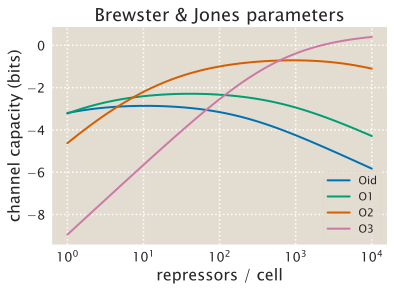

In [160]:
# Plot curves

# Loop through operators
for i, key in enumerate(kon_dict.keys()):
    plt.semilogx(R_array, channel_cap[i], label=key)

plt.xlabel('repressors / cell')
plt.ylabel('channel capacity (bits)')
plt.title('Brewster & Jones parameters')
plt.legend()

Basically all of the values are negative. That means that the small noise approximation is broken for this parameter regime since the normalization constant $\mathcal{Z}$ is small compared to $\sqrt{2\pi e}$.

#### Self-consistent values of $k_o / \kon$ and $\depsilon_{RA}$

Let's now try constraining the values of the constants such that they are self-consistent with the binding energies reported by Garcia & Phillips to see if this helps with the error.

In [154]:
# Define dictionary containing the kon rates according to Jones & Brewster
eRA_dict = {'Oid': -17, 'O1': -15.3, 'O2': -13.9, 'O3': -9.7}

# Prepare dictionary with all relevant parameters
sma_params = dict(gamma_m=0.00284, r_gamma_m=15.7,
                ko=2.7E-3)

# Define array of number of repressors to evaluate
R_array = np.logspace(0, 4, 100)

In [155]:
# Initialize matriz to save channel capacities
channel_cap = np.zeros([len(kon_dict), len(R_array)])

# Loop through operators
for i, key in enumerate(eRA_dict.keys()):
    print(key)
    # Modify kon parameter in dictionary
    sma_params['kon'] = chann_cap.kon_fn(k0=sma_params['ko'],
                                         epsilon=eRA_dict[key])
    # Loop through repressor copy number
    for j, r in enumerate(R_array):
        # Modify repressor parameter in dictionary
        sma_params['R'] = r
        # Compute and save channel capacity
        channel_cap[i, j] = sma_mRNA_num(**sma_params)

Oid
O1
O2
O3


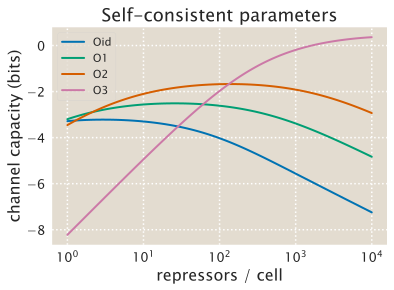

In [156]:
# Plot curves

# Loop through operators
for i, key in enumerate(kon_dict.keys()):
    plt.semilogx(R_array, channel_cap[i], label=key)

plt.xlabel('repressors / cell')
plt.ylabel('channel capacity (bits)')
plt.title('Self-consistent parameters')
plt.legend()

The issue remains with this parameter set.

#### Using fit parameters from YFP data.

The final option to explore is using the parameters fit from the YFP data.

**Note**: This is still work in progress, so these parameters might or might not be valid.

In [161]:
ko = 0.0000384 # Fit to YFP expression data.

# Prepare dictionary with all relevant parameters
sma_params = dict(gamma_m=0.00284, r_gamma_m=15.7, ko=ko)

# Define array of number of repressors to evaluate
R_array = np.logspace(0, 4, 100)

In [162]:
# Initialize matriz to save channel capacities
channel_cap = np.zeros([len(kon_dict), len(R_array)])

# Loop through operators
for i, key in enumerate(eRA_dict.keys()):
    print(key)
    # Modify kon parameter in dictionary
    sma_params['kon'] = chann_cap.kon_fn(k0=sma_params['ko'],
                                         epsilon=eRA_dict[key])
    # Loop through repressor copy number
    for j, r in enumerate(R_array):
        # Modify repressor parameter in dictionary
        sma_params['R'] = r
        # Compute and save channel capacity
        channel_cap[i, j] = sma_mRNA_num(**sma_params)

Oid
O1
O2
O3


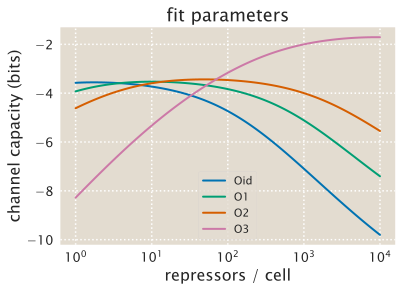

In [163]:
# Plot curves

# Loop through operators
for i, key in enumerate(kon_dict.keys()):
    plt.semilogx(R_array, channel_cap[i], label=key)

plt.xlabel('repressors / cell')
plt.ylabel('channel capacity (bits)')
plt.title('fit parameters')
plt.legend()

It seems that for these experimentally relevant parameters and realistic model of transcription the small-noise approximation seems not to work at all.